### Notebook to calculate image-by-image zeropoints. 

In [1]:
#standard imports
%matplotlib inline
import numpy as np

import astropy.coordinates as coords
from astropy.coordinates import Angle
import astropy.units as u

import matplotlib.pyplot as plt
import seaborn as sea

import pandas as pd

import os

def write_reg(ra,dec,size='2"',color='green',shape='circle',filename='regions.reg', width=1):
    f = open(filename,'w')
    f.write('fk5\n')
    for i,j in zip(ra,dec):
        f.write(shape+' '+str(i)+' '+str(j)+' '+size+' # color='+color+ ' width='+str(width)+'\n')
    f.close()     

## Specify some relevant info about the galaxy.

In [2]:
#specify the filter to use for sdss (i.e. 'gmag','rmag','imag')
filt = 'r'

#specify the bright and faint cuts for PanSTARRS phot comparison. These probably don't need
#to be tweaked too much.
ps1_faint_cut = 20
ps1_bright_cut = 12

#specify the data file that contains our photometry
phot_file = 'ngvs_bg1_r_uncorrected.csv'

#specify the cuts for our photometry to calcualte zero-points. These should generally match those used for 
#calculating the aperture corrections.
fwhm_max = 3.5
fwhm_min = 3.1
faint_cut = 20
bright_cut = 18

#specify the aperture correction that we calculated for this image.
aper_cor = 0.2584

#specify the initial zeropoint that was used for initial photometry. this is whatever is in the .seconfig file
#for aperture corrections.
init_zpt = 30.0

#specify the mag to use for the PanSTARRS data. Usually this will just mean changing the correct filter.
ps_mag = 'rMeanPSFMag'

#specify the matching radius to be used between our data and the PanSTARRS data. Usually this shouldn't matter,
#I think one arcsec is usually good.
match_rad = 5.*u.arcsec

### Pull down and read in PanSTARRS data
PanSTARRS data can be pulled down from the PanSTARRS casjobs server. Use the standard query format, it follows pretty typical SQL. Coordinates for the pointing need to be updated in the query. After querying data, download it and then read in the file you saved using pandas and calculate some additional difference arrays.

In [3]:
#read in the data you pulled down from the panstarrs database
ps1 = pd.read_csv('ngvs_bg_1_zp.csv')

#calculate some difference arrays that we will use for star/galaxy seperation. More conveinent to calc them here.
ps1['gdiff'] = ps1['gMeanPSFMag'] - ps1['gMeanKronMAg']
ps1['rdiff'] = ps1['rMeanPSFMag'] - ps1['rMeanKronMag']
ps1['idiff'] = ps1['iMeanPSFMag'] - ps1['iMeanKronMag']

### Set proposed stellar cuts in mag difference: 
Here we want to seperate out extended sources from point sources, as we only are calibrating by comparing our own stars to those we find in the images. 

In [4]:
#here we select magnitude cuts to choose point sources. Similar to aperture corrections, iterate on these
#values until a reasonable selection is found in the plots.

#The differences are calculated between PSF mags and Kron mags. PSF mags reflect the full light
#profile, while Kron mags are defined to some fixed aperture, so PSF mags are slightly brighter (i.e. lower).
#In other words, stars will have slightly negative values for (psf_mag - kron_mag). As a result, 0.0
#will usually achieve good seperation, but verify using plots below. 
g_diff_cut = 0.0
r_diff_cut = 0.0
i_diff_cut = 0.0

#Faint magnitude cuts are less well defined. Just pick values that seem to cut off sources when the scatter
#of the point-source locus seems to grow
g_mag_cut = 21
r_mag_cut = 21
i_mag_cut = 20.5

ps_stars = ps1[(ps1['gdiff'] < g_diff_cut) & \
               (ps1['rdiff'] < r_diff_cut) & \
               (ps1['idiff'] < i_diff_cut) & \
               (ps1['gMeanPSFMag'] < g_mag_cut) & \
               (ps1['rMeanPSFMag'] < r_mag_cut) & \
               (ps1['iMeanPSFMag'] < i_mag_cut)].reset_index(drop=True)

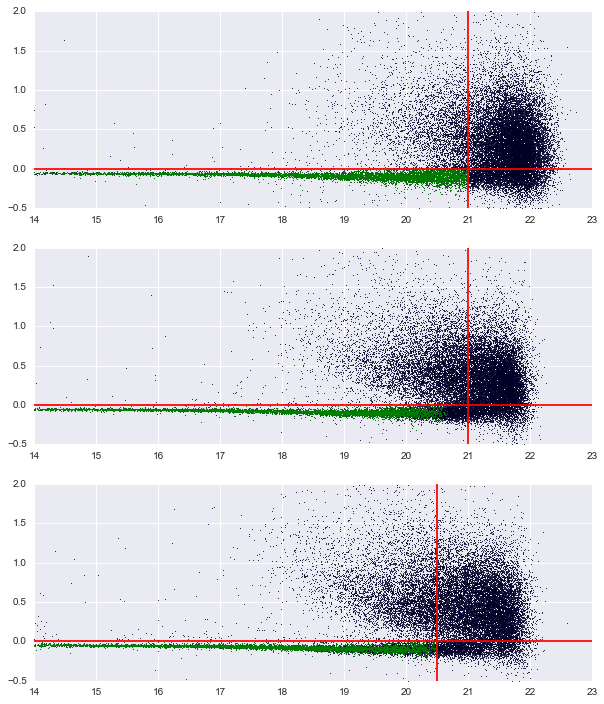

In [5]:
fig,ax = plt.subplots(figsize=(10,12),nrows=3)
ax[0].scatter(ps1['gMeanPSFMag'],ps1['gdiff'],s=0.5)
ax[0].set_ylim(-0.5,2)
ax[0].set_xlim(14,23)
ax[0].axhline(g_diff_cut,color='r')
ax[0].axvline(g_mag_cut,color='r')
ax[0].scatter(ps_stars['gMeanPSFMag'],ps_stars['gdiff'],s=0.5,color='g')

ax[1].scatter(ps1['rMeanPSFMag'],ps1['rdiff'],s=0.5)
ax[1].set_ylim(-0.5,2)
ax[1].set_xlim(14,23)
ax[1].axhline(r_diff_cut,color='r')
ax[1].axvline(r_mag_cut,color='r')
ax[1].scatter(ps_stars['rMeanPSFMag'],ps_stars['rdiff'],s=0.5,color='g')


ax[2].scatter(ps1['iMeanPSFMag'],ps1['idiff'],s=0.5)
ax[2].set_ylim(-0.5,2)
ax[2].set_xlim(14,23)
ax[2].axhline(i_diff_cut,color='r')
ax[2].axvline(i_mag_cut,color='r')
ax[2].scatter(ps_stars['iMeanPSFMag'],ps_stars['idiff'],s=0.5,color='g')


In [6]:
#write out a region file containing the good comparisons, for reference. This isn't required but can be useful.
#Make sure to correct the file name if necessary.
write_reg(ps_stars['raMean'],ps_stars['decMean'],filename='ps1_matched_g.reg',width=2,size='5"')

### Photometry comparisons with our data.
Now we need to compare the PanSTARRS photometry with our own photometry. We do this by reading in our un-calibrated
data and comparing the photometry measurements with our selected data. The code below applies the cuts specified in the variables above, but those can of course be changed if necessary. However, in general the same stars that worked well for aperture corrections will also work well for zero-point calibrations.

In [7]:
#read in our photometry from the specified phot_file as a pandas data frame. The code assumes
#the catalog has been written in the format from the aperture corrections notebook, but that can be changed if
#necessary.
data = pd.read_csv(phot_file,delimiter=' ',names=['ra','dec','mag','merr','fwhm','ellip','flag'])

In [8]:
#cut our data to select only good comparison stars using values defined above
good_data = (data['mag'] < faint_cut) & (data['mag'] > bright_cut) & \
    (data['fwhm'] > fwhm_min) & (data['fwhm'] < fwhm_max) & (data['flag'] < 1)
    
cut_data = data[good_data].reset_index(drop=True)

#apply aperture corrections to our measured photometry
cut_data['mag'] = cut_data['mag'] - aper_cor 

In [9]:
#write out the stars we are selecting to compare to. Again, not necessary, but can be useful.
write_reg(cut_data['ra'],cut_data['dec'],filename='scam_good_g.reg',width=2,size='5"',color='red')

In [10]:
#match our photometry with corresponding sources in PanSTARRS
ra_meas = cut_data['ra']
dec_meas = cut_data['dec']

#astropy coordinate object to hold 
measured_coords = coords.SkyCoord(ra=ra_meas*u.degree,\
    dec=dec_meas*u.degree)

ps1_coords = coords.SkyCoord(ra=ps_stars['raMean'] * u.degree,\
                             dec=ps_stars['decMean'] * u.degree)

#perform the matching
full_old,full_new,d2d,d3d = ps1_coords.search_around_sky(measured_coords,match_rad)

In [11]:
#calculate differences between our measured photometry
diffs = cut_data.ix[full_old,:]['mag'].as_matrix() - ps_stars.ix[full_new,:][ps_mag].as_matrix()

### Plot differences in photometry as a function of magnitude, and verify that scatter looks reasonable.
The actual location of the offset could be over a wide range, but the scatter should hopefully be small. If the standard deviation is greater than $\sim0.1$ mag, probably need to investigate and verify photometry looks good.

(-0.5, 0.5)

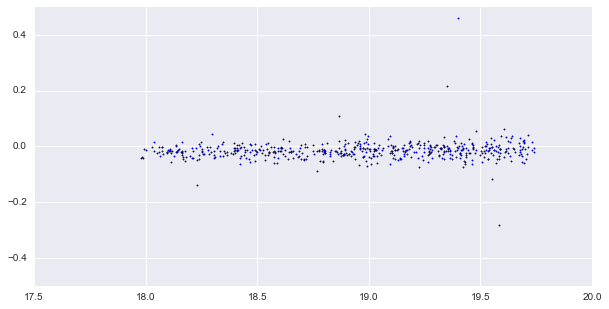

In [12]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(cut_data.ix[full_old,:]['mag'].as_matrix(),diffs,s=2)
ax.set_ylim(-0.5,0.5)

In [13]:
#Check that the number of sources and the standard deviation are reasonable.
print('Number of sources: ',diffs.shape)
print('Std: ',np.std(diffs))

Number of sources:  (536,)
Std:  0.0344133905547


### Calculate the final shift. Actual zeropoint is whatever was used to make initial catalog plus the below value.

In [18]:
zpt_shift = np.median(diffs)
print('Zero-point shift: ',zpt_shift)
print('New zero-point: ',init_zpt - zpt_shift )

Zero-point shift:  -0.0158007568359
New zero-point:  30.0158007568


### Finally, update the final .seconfig file with the updated zero point and the final measurement aperture
This updated .seconfig file will be used to make the final photometric catalog of the field, as well as to conduct fake star tests to estimate completeness curves of the images.

This step runs a new completeness .seconfig file. Make sure this file has:
1. Updated catalog name.
2. Updated aperture magnitude that matches the measurement aperture.
3. Updated zero-point, as calculated above.

Also make sure that the completeness.param folder has been copied into the correct new folder. After the .seconfig file looks good, updated the filenames below to correspond to the correct .seconfig file, image, and catalog.

In [23]:
#Specify the file name for the updated .seconfig file
seconfig_file = 'ngvs_bg1_r_completeness.seconfig'

#specify the image file
file = 'NGVS_BG_1.R.fits'

#also specify the name of the catalog we're reading in. This should match what was in the .seconfig file.
catalog_file = 'ngvs_bg_1_r_completeness.cat'

In [24]:
#run source extractor using the updated file
run = os.system("sex -c "+ seconfig_file + ' ' + file)

In [25]:
#read in the catalog file, verify that it looks good, and then write out with more useful headers
catalog = pd.read_csv(catalog_file,delim_whitespace=True,comment='#',\
                      names=['ra','dec','mag','merr','fwhm','ellip','flag'])

#apply the aperture correction here as well
catalog['mag'] = catalog['mag'] - aper_cor

In [26]:
#output the final catalog in .csv format
catalog.to_csv('ngvs_bg_1_r_final.csv')